In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import os 
import sys
from Backtester import Backtester
from simulator import Simulator
from utils import *
from datetime import datetime


os.chdir('/Users/yinki/OneDrive/Python/Crypto Whales')
print(os.getcwd())

Pool_address = '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed' # WETH/WBTC pool 0.3% fee
simulator = Simulator(Address='0xcbcdf9626bc03e24f779434178a73a0b4bad62ed')


c:\Users\yinki\OneDrive\Python\Crypto Whales
c:\Users\yinki\OneDrive\Python\Crypto Whales
Initializing Backtester...


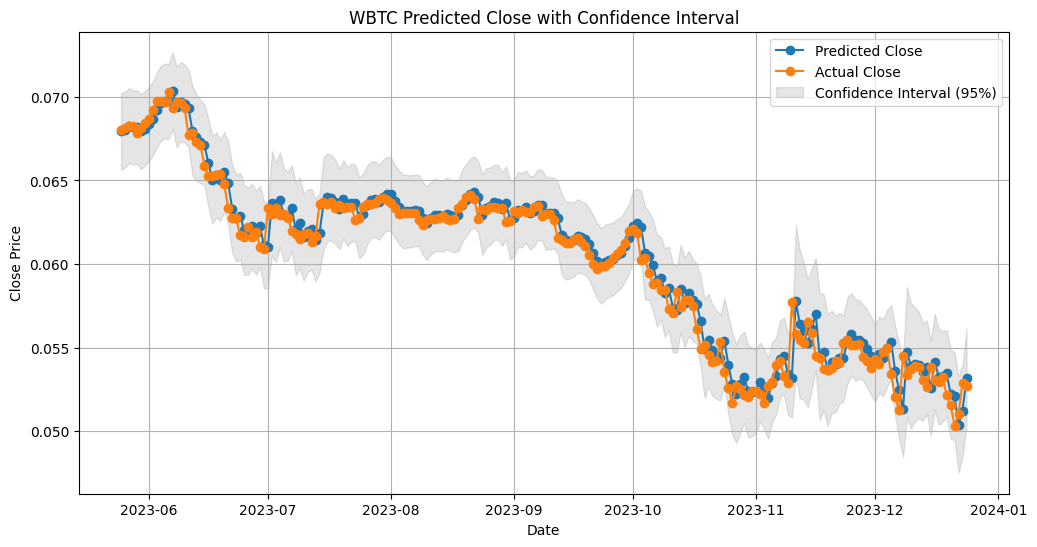

In [44]:
# Looking over our test period as well as our ARIMA-GARCH predictions

start_date = "2023-05-25"
end_date = "2023-12-24"
df = pd.read_csv('data/pools_daily_weth_btc_arima_garch.csv', index_col=0, parse_dates=True, sep=';').loc['2023-05-25':'2023-12-24']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Predicted Close (WBTC)'], label='Predicted Close', marker='o')
plt.plot(df.index, df['Close (WBTC)'], label='Actual Close', marker='o')
plt.fill_between(df.index, df['Predicted Close (WBTC)'] - 1.96 * df['Conditional Volatility'], df['Predicted Close (WBTC)'] + 1.96 * df['Conditional Volatility'], color='gray', alpha=0.2, label='Confidence Interval (95%)')
plt.title('WBTC Predicted Close with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Simulating based on our desired parameters initial investment, number of individual windows and risk level

risk_param = 0.95
initial_investment = 1000000
windows = 5

results = simulator.simulate(windows, risk_param, initial_investment)

Total Months: 7
Test Period: 2023-05-25 to 2023-07-05
Lower Bound: 0.05995156003587719, Upper Bound: 0.07032738733401193


c:\Users\yinki\OneDrive\Python\Crypto Whales\src\simulator.py:50: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']
c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']
c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']


Initial Investment USD: 1000000, BTC-USD: 26225.4140625
Initial Amounts: 19.065475908536953 token0, 280.1827242846707 token1
Final Amounts: 7.183935373464371 token0, 454.7916567752964 token1
Simulated Position returned 1.0040595105704428 in  41  days, for an APR of  8.93857856971248
Base position returned 5.552831370553458e-17 in  41  days, for an APR of  4.943374268907347e-16
Fees in token 0 and token 1 0.16828579580482117 3.5320128318676494
Total Fees in USD 15334.657838801346
Your liquidity was active for: 41.82384406982945
Final Net Liquidity Value of LP Investment (WBTC):  38.09871257441298
{'coin': 'ETH', 'strike_price': 1074.9640869140624, 'Time to Expiry': 0.11232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1791.6068115234375}
{'coin': 'ETH', 'strike_price': 1254.1247680664062, 'Time to Expiry': 0.11232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1791.6068115234375}
{'coin': 'ETH', 'strike_price': 1433.28544921875, 'Time t

c:\Users\yinki\OneDrive\Python\Crypto Whales\src\simulator.py:50: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']
c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']
c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']


Initial Investment USD: 1121051.8261313785, BTC-USD: 30405.30078125
Initial Amounts: 18.435137908957905 token0, 293.758114350747 token1
Final Amounts: 17.617014976945587 token0, 306.79464551215824 token1
Simulated Position returned 0.9555754443060122 in  41  days, for an APR of  8.506952126138888
Base position returned 2.8266246137958677e-17 in  41  days, for an APR of  2.516385326915833e-16
Fees in token 0 and token 1 0.17259080994432377 2.8718393332674172
Total Fees in USD 13703.770646758674
Your liquidity was active for: 25.24572273075174
Final Net Liquidity Value of LP Investment (WBTC):  36.8750409104584
{'coin': 'ETH', 'strike_price': 1142.414208984375, 'Time to Expiry': 0.11232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1904.023681640625}
{'coin': 'ETH', 'strike_price': 1332.8165771484373, 'Time to Expiry': 0.11232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1904.023681640625}
{'coin': 'ETH', 'strike_price': 1523.218945312

c:\Users\yinki\OneDrive\Python\Crypto Whales\src\simulator.py:50: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']


Initial Investment USD: 1074339.0806070005, BTC-USD: 28534.513671875
Initial Amounts: 18.825256546529495 token0, 299.61167806595864 token1
Final Amounts: 8.572437085328726 token0, 462.7895044124469 token1
Simulated Position returned 1.0265991456833505 in  41  days, for an APR of  9.139236296937145
Base position returned 3.5489989278674605e-17 in  41  days, for an APR of  3.1594746552966414e-16
Fees in token 0 and token 1 0.17539451623265176 3.515565876523378
Total Fees in USD 15704.767004697547
Your liquidity was active for: 32.44853668256188
Final Net Liquidity Value of LP Investment (WBTC):  37.56453413363528
{'coin': 'ETH', 'strike_price': 1075.9048095703124, 'Time to Expiry': 0.11232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1793.1746826171875}
{'coin': 'ETH', 'strike_price': 1255.222277832031, 'Time to Expiry': 0.11232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1793.1746826171875}
{'coin': 'ETH', 'strike_price': 1434.53974

c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']
c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']


Total Premiums: 14704.992848469921
Fees: 15704.767004697547, Hedging Costs: 14704.992848469921, Payoff: 0
Current Value USD at end of period 2023-08-17 to 2023-09-27: 970111.6541562236 USD
HODL 50-50- Start Value: 1066726.2428071275, End_Value: 945063.3285434198
-------------------------------------------------------------------
Test Period: 2023-09-28 to 2023-11-08
Lower Bound: 0.05096998373731466, Upper Bound: 0.06294894656833089


c:\Users\yinki\OneDrive\Python\Crypto Whales\src\simulator.py:50: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']
c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']
c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']


Initial Investment USD: 970111.6541562236, BTC-USD: 26419.205078125
Initial Amounts: 18.359970545810864 token0, 302.1839857080772 token1
Final Amounts: 4.346006927452763 token0, 532.8376989695987 token1
Simulated Position returned 1.678826910432229 in  41  days, for an APR of  14.945654202628381
Base position returned 1.1777664519753856e-16 in  41  days, for an APR of  1.0484994023683311e-15
Fees in token 0 and token 1 0.2952161246588706 6.585169086114717
Total Fees in USD 28881.401745623105
Your liquidity was active for: 52.56672845930008
Final Net Liquidity Value of LP Investment (WBTC):  37.1765061450788
{'coin': 'ETH', 'strike_price': 961.28876953125, 'Time to Expiry': 0.11232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1602.14794921875}
{'coin': 'ETH', 'strike_price': 1121.503564453125, 'Time to Expiry': 0.11232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1602.14794921875}
{'coin': 'ETH', 'strike_price': 1281.718359375, 'Time

c:\Users\yinki\OneDrive\Python\Crypto Whales\src\simulator.py:50: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']
c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']
c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']


Initial Investment USD: 1225498.4228303963, BTC-USD: 35857.17578125
Initial Amounts: 17.088607735124793 token0, 323.1142966162176 token1
Final Amounts: 15.946144485522083 token0, 344.71618572427496 token1
Simulated Position returned 4.352895144338165 in  45  days, for an APR of  35.30681617074289
Base position returned 1.8623690671556205e-16 in  45  days, for an APR of  1.5105882433595589e-15
Fees in token 0 and token 1 0.7495454660198754 13.818807280625727
Total Fees in USD 66093.74751530075
Your liquidity was active for: 57.016916049364376
Final Net Liquidity Value of LP Investment (WBTC):  34.235115039886125
{'coin': 'ETH', 'strike_price': 1138.462353515625, 'Time to Expiry': 0.1232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1897.437255859375}
{'coin': 'ETH', 'strike_price': 1328.2060791015624, 'Time to Expiry': 0.1232876712328767, 'staking_apy': 0.0515, 'Type': 'PUT', 'Close Price (USD)': 1897.437255859375}
{'coin': 'ETH', 'strike_price': 1517.949804687

c:\Users\yinki\OneDrive\Python\Crypto Whales\src\simulator.py:50: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return self.btc_price.loc[date, 'Close']


Window 1
Window 2
Window 3
Window 4
Window 5


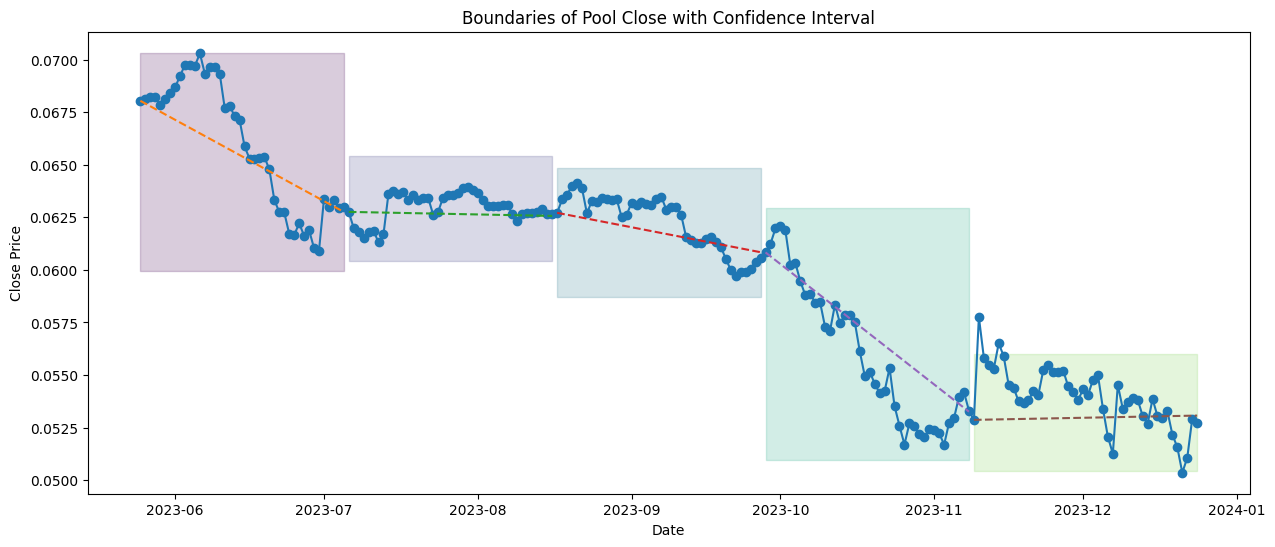

In [46]:
# Plot the windows
# Plotting
start_dates = results['Start Date']
end_dates = results['End Date']
start_prices = results['Start Price (WBTC)']
end_prices = results['End Price (WBTC)']
lower_bounds = results['Lower Bound']
upper_bounds = results['Upper Bound']
df.index = pd.to_datetime(df.index)

cmap = cm.get_cmap('viridis')

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close (WBTC)'], label='Predicted Close', marker='o')
plt.title('Boundaries of Pool Close with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Close Price')
# Plotting each window with its boundaries
for i, (start_date, end_date, start_price, end_price, lower_bound, upper_bound) in enumerate(zip(start_dates, end_dates, start_prices, end_prices, lower_bounds, upper_bounds)):
    print(f'Window {i + 1}')
    #print(f'Start Date: {start_date}')
    #print(f'End Date: {end_date}')
    #print(f'Start Price: {start_price}')
    #print(f'End Price: {end_price}')
    window = df[(df.index >= start_date) & (df.index <= end_date)]
    #print(window)
    color = cmap(i / windows)
    # Convert DatetimeIndex to list of strings for plotting dotted line
    date_strings = [str(date) for date in window.index]

    # Plot the start and end prices as a dotted line
    plt.plot(window.index[[0, -1]], [start_price, end_price], linestyle='--', label=f'Estimated Trend Line {i + 1}')

    # Plot the lower and upper bounds
    plt.fill_between(window.index, lower_bound, upper_bound, color=color, alpha=0.2, label=f'Bounds {i + 1}')

In [47]:
window = df.loc[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]
#window

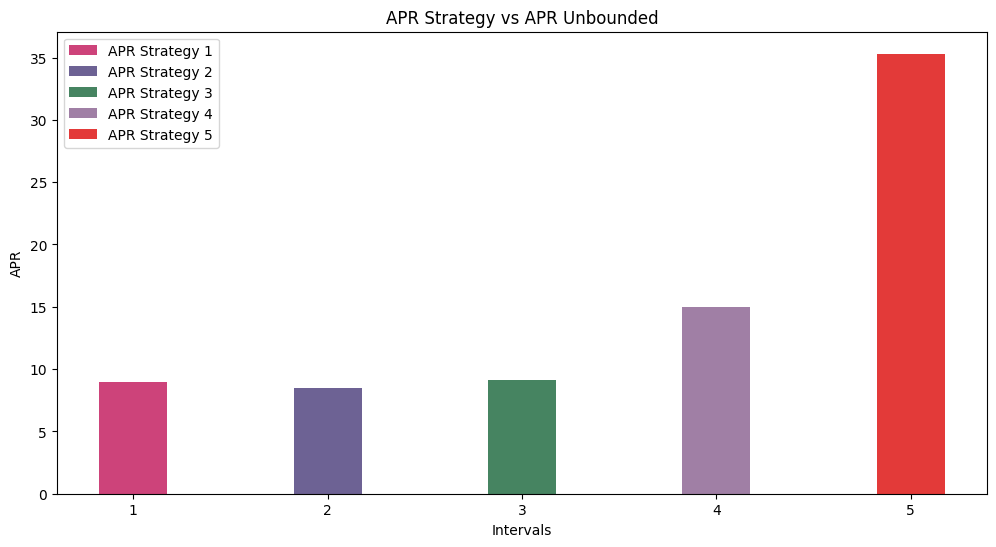

,APR Strategy,APR Unbounded
1,8.938579,4.943374e-16
2,8.506952,2.516385e-16
3,9.139236,3.159475e-16
4,14.945654,1.048499e-15
5,35.306816,1.510588e-15


In [48]:
results.keys()

# Plotting APR Strategy vs APR Unbounded Bar Graphs

# Generate x-axis values
intervals = np.arange(1, windows + 1)
colors = np.random.rand(len(intervals), 3)
# Plotting APR Strategy
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
bar_positions_strategy = intervals 
for i, (position, apr) in enumerate(zip(bar_positions_strategy, results['APR Strategy'])):
    ax.bar(position, apr, bar_width, label=f'APR Strategy {i+1}', alpha=0.8, color=colors[i])
#ax.bar(bar_positions_unbounded, results['APR Unbounded'], bar_width, label='APR Unbounded', alpha=0.8)
ax.set_xlabel('Intervals')
ax.set_ylabel('APR')
ax.set_title('APR Strategy vs APR Unbounded')
ax.set_xticks(intervals)
ax.legend()
plt.show()

'''
# Plotting APR Unbounded
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
bar_positions_unbounded = intervals 
ax.bar(bar_positions_unbounded, results['APR Unbounded'], bar_width, label='APR Unbounded', alpha=0.8, color='orange')
ax.set_xlabel('Intervals')
ax.set_ylabel('APR')
ax.set_title('APR Strategy')
ax.set_xticks(intervals)
ax.legend()
plt.show()
'''


# Table of APRs
apr_results = pd.DataFrame({
    'APR Strategy': results['APR Strategy'],
    'APR Unbounded': results['APR Unbounded']
}, index=intervals)
apr_results

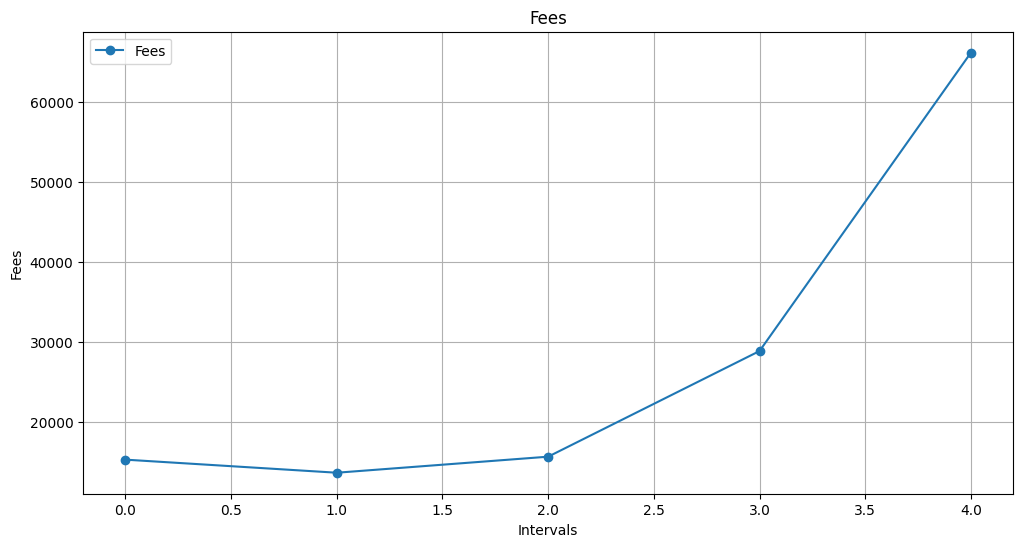

In [49]:
# Plot Fees line graph
plt.figure(figsize=(12, 6))
plt.plot(results['Fee USD'], label='Fees', marker='o')
plt.title('Fees')
plt.xlabel('Intervals')
plt.ylabel('Fees')
plt.legend()
plt.grid(True)
plt.show()

[0, 0, 0, 4691.745117187496, 734.8332519531236]


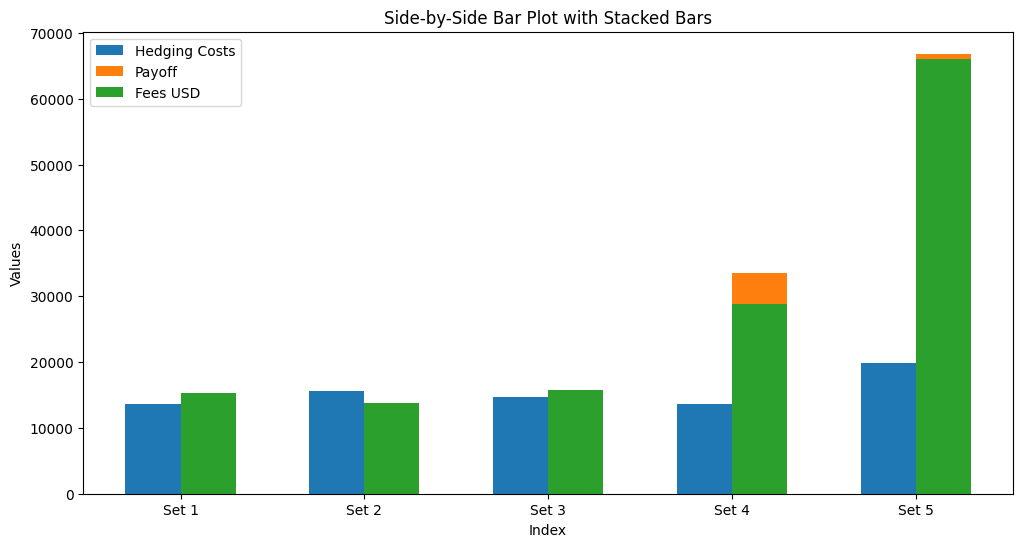

In [50]:
# Data
hedging_costs = results['Hedging Costs']
payoff = results['Payoff']
print(payoff)
fees_usd = results['Fee USD']

# Number of sets
num_sets = len(hedging_costs)

# Set up the index for each set
index = np.arange(num_sets)

# Bar width
bar_width = 0.3

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar1 = ax.bar(index, hedging_costs, bar_width, label='Hedging Costs')
bar2 = ax.bar(index + bar_width, payoff, bar_width, label='Payoff', bottom=fees_usd)
bar3 = ax.bar(index + bar_width, fees_usd, bar_width, label='Fees USD')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Side-by-Side Bar Plot with Stacked Bars')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'Set {i+1}' for i in range(num_sets)])
ax.legend()

plt.show()

Text(0.5, 0, 'Intervals')

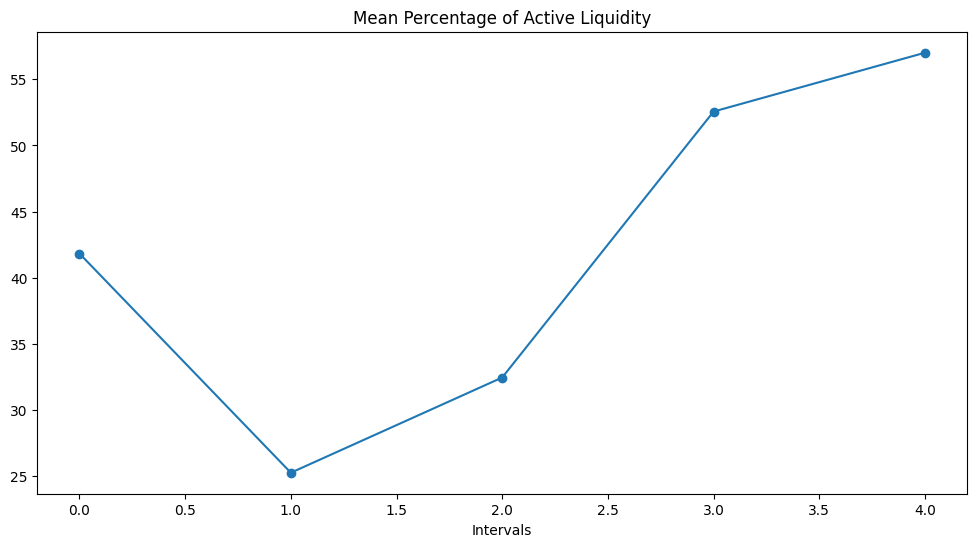

In [51]:
# Plot Mean Percentage of Active Liquidity
plt.figure(figsize=(12, 6))
plt.plot(results['Mean Percentage of Active Liquidity'], label='Mean Percentage of Active Liquidity', marker='o')
plt.title('Mean Percentage of Active Liquidity')
plt.xlabel('Intervals')


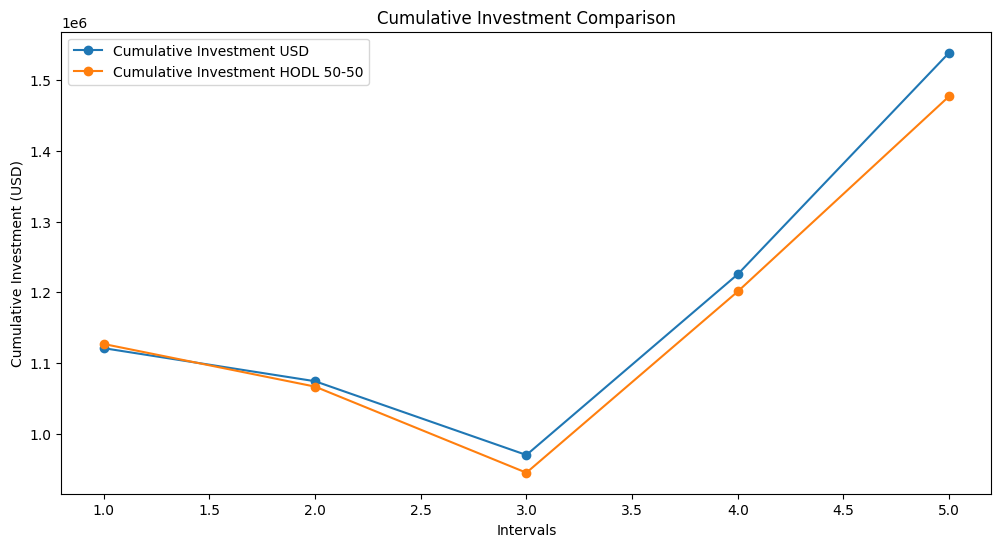

<AxesSubplot: title={'center': 'Cumulative Investment Comparison'}>

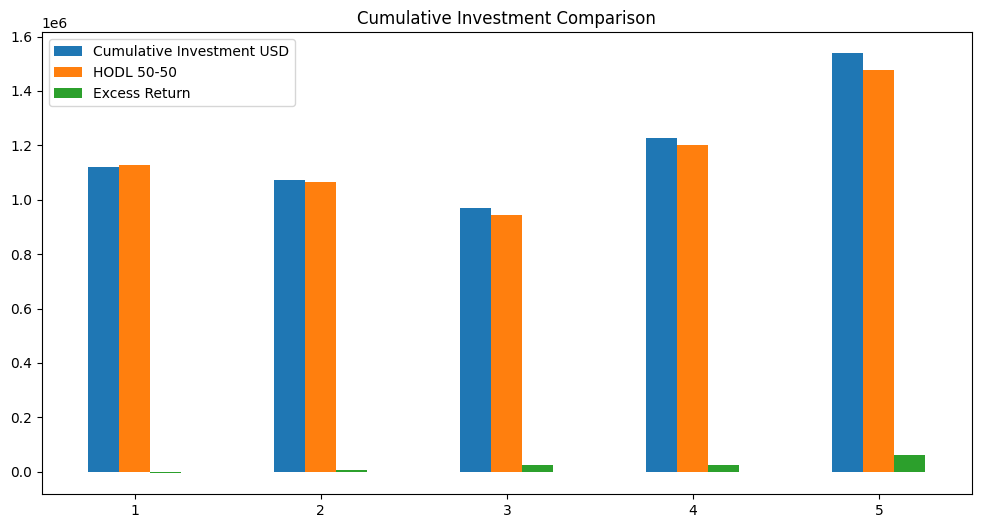

In [52]:
# Plot Cumulative Investment USD vs HODL 50-50

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(intervals, results['Cumulative Investment USD'], label='Cumulative Investment USD', marker='o')
ax.plot(intervals, results['HODL 50-50'], label='Cumulative Investment HODL 50-50', marker='o')

ax.set_xlabel('Intervals')
ax.set_ylabel('Cumulative Investment (USD)')
ax.set_title('Cumulative Investment Comparison')
ax.legend()

plt.show()


# Show Table of Cumulative Investment USD vs HODL 50-50
cumulative_results = pd.DataFrame({
    'Cumulative Investment USD': results['Cumulative Investment USD'],
    'HODL 50-50': results['HODL 50-50']
}, index=intervals)
cumulative_results['Excess Return'] = (cumulative_results['Cumulative Investment USD'] - cumulative_results['HODL 50-50'])

cumulative_results.plot.bar(figsize=(12, 6), rot=0, title='Cumulative Investment Comparison')

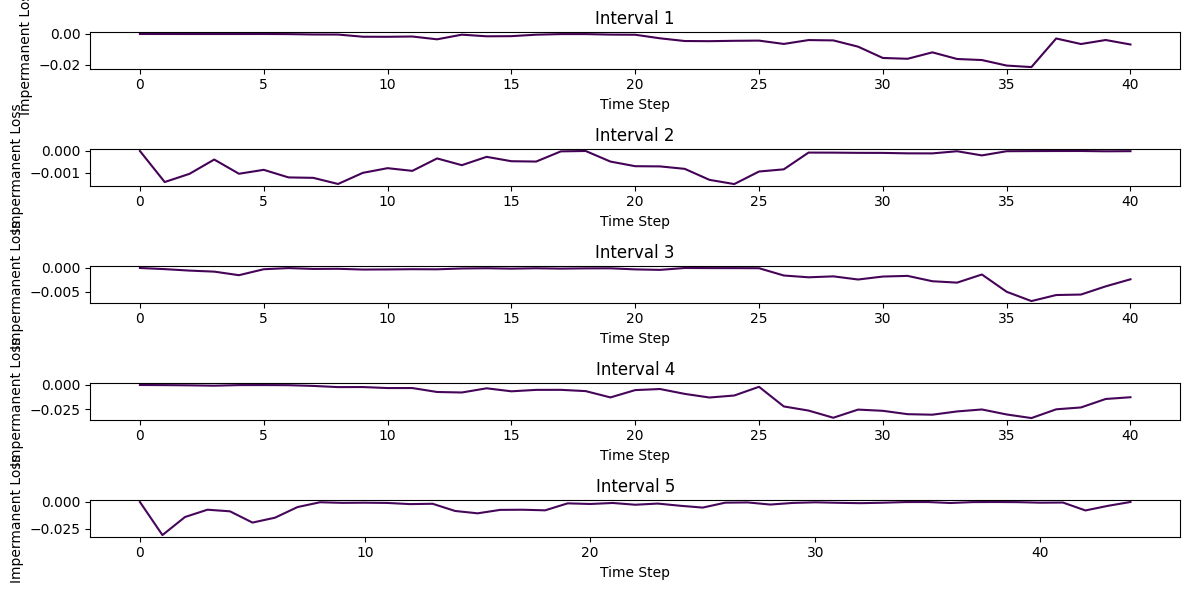

,Mean,Standard Deviation,Minimum,Maximum
1,-0.004774,0.006017,-0.021360,0.0
2,-0.000531,0.000492,-0.001515,0.0
3,-0.001318,0.001779,-0.006939,0.0
4,-0.012122,0.011355,-0.033988,0.0
5,-0.004123,0.006018,-0.030948,0.0


In [53]:

IL = results['Impermanent Loss']
#x_values = [i for i in range(1, windows + 1)]
x_values = [i for i in range(sum([len(i) for i in IL]))]
# Plotting
fig, axs = plt.subplots(nrows=len(IL), figsize=(12, 6))
colors = cm.viridis(range(len(IL)))

for i, (ax, data) in enumerate(zip(axs, IL)):
    ax.plot(data, color=colors[i])
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Impermanent Loss')
    ax.set_title(f'Interval {i + 1}')

plt.tight_layout()
plt.show()

IL_Statistics = []
for i in range(len(IL)):
    IL_Statistics.append([np.mean(IL[i]), np.std(IL[i]), np.min(IL[i]), np.max(IL[i])])

IL_Statistics = pd.DataFrame(IL_Statistics, columns=['Mean', 'Standard Deviation', 'Minimum', 'Maximum'], index=[i for i in range(1, windows + 1)])
IL_Statistics

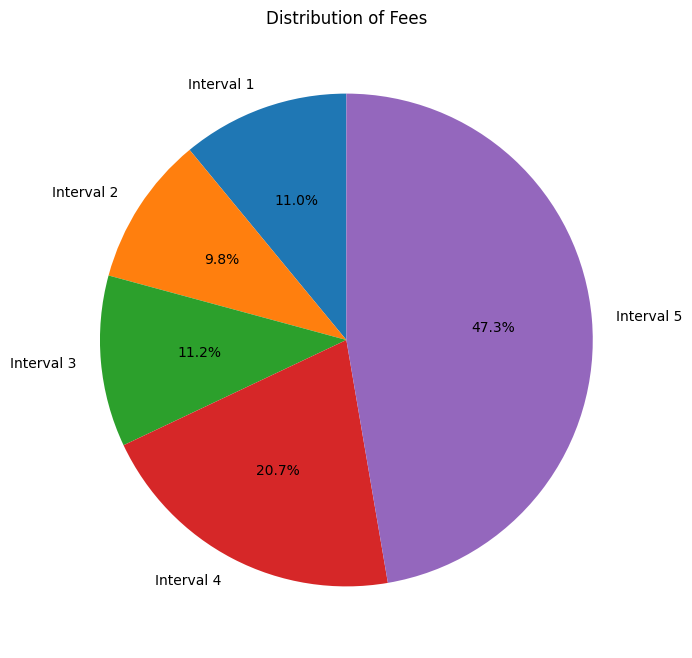

In [54]:
# Pie Chart of Fees Earned, dont really say much
fees = results['Fee USD']

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(fees, labels=[f'Interval {i+1}' for i in range(len(fees))], autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Fees')
plt.show()